This notebook may be used in Google Colab. To access press this button:

<a href="https://colab.research.google.com/github/elzurdo/multi_objective_optimisation/blob/master/01_knapsack%202D_exhaustive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>


In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Data 

Packages setup

In [3]:
seed = 3141592653

N_PACKAGES = 20

MIN_WEIGHT = 0.1
MAX_WEIGHT = 10

MIN_VALUE = 0.1
MAX_VALUE = 100

value_distribution_mode = 'random' # 'squared'
noise_factor = 1./2  # examine results of noise_factor = 0 in 'squared' mode, too!
# ---------------

np.random.seed(seed)

weights = np.abs(np.random.normal(MIN_WEIGHT, MAX_WEIGHT, N_PACKAGES))

if 'squared' == value_distribution_mode:
    values =  weights ** 2 
    values += values * np.random.normal(0, noise_factor, len(weights))
    values = np.abs(values)
elif 'random' == value_distribution_mode:
    values = np.abs(np.random.normal(MIN_VALUE, MAX_VALUE, N_PACKAGES))

In [4]:
packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(N_PACKAGES)}

[package for ipackage, package in packages.items()][:4]

[{'weight': 16.045064716419265, 'value': 122.44920604368212},
 {'weight': 10.257933643337433, 'value': 34.08475741925324},
 {'weight': 7.427142915985984, 'value': 7.3477194585976235},
 {'weight': 16.1061446548582, 'value': 75.21497126311662}]

Text(0.5, 1.0, 'Packages')

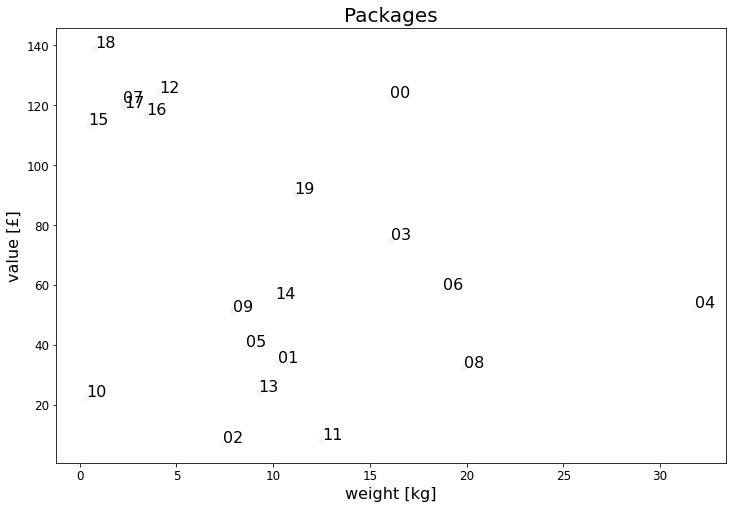

In [5]:
plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )

for idx_package, package in packages.items():
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')

# Scoping Challenge


**Combinations**.   

An unordered arrangement of $k$ objects from a set of $n$ 
$$
_nC_k=\frac{n!}{(n-k)!k!}\equiv {n \choose k}
$$

Here we use     
`k = N_PACKAGES_PER_KNAPSACK`  
`n = N_PACKAGES`,  
with assumptions for siplicity:  
* A package can appear only once in a a knapsack.  
* The order of a package assigned to a knapsack does not matter.  


In [6]:
from math import factorial

In [9]:
def pretty_int(x):
    if x > 1.e6:
        return f'{int(x):0.1e}'
    else:
        return f'{int(x):,}'

N_PACKAGES_PER_KNAPSACK = 4
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)/factorial(k)/factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 4,845 combinations of 20 choose 4.'

# Defining The Decision Space

We decide which knapsack(s) to choose.

In [16]:
from itertools import combinations 

package_combinations = combinations(packages.keys(), N_PACKAGES_PER_KNAPSACK)

# Defining The Objective Space

We determine that we want to optimise for two objectives: 
* knapsack value 
* knapsack weight  

In [13]:
objectives = ['weight', 'value']

In [17]:
def knapsack_objective(knapsack, objective, packages):
    knapsack[objective] = np.sum([packages[idx_package][objective] for idx_package in knapsack['packages']])
 
knapsacks = {}
for idx_knapsack, this_idxs_packages in enumerate(list(package_combinations)):
    knapsacks[idx_knapsack] = {}
    knapsacks[idx_knapsack]['packages']= this_idxs_packages
    
    for objective in objectives:
        knapsack_objective(knapsacks[idx_knapsack], objective, packages)
        
[knapsack for _, knapsack in knapsacks.items()][:4]

[{'packages': (0, 1, 2, 3),
  'weight': 49.83628593060088,
  'value': 239.0966541846496},
 {'packages': (0, 1, 2, 4),
  'weight': 65.53925805317334,
  'value': 216.3501454683599},
 {'packages': (0, 1, 2, 5),
  'weight': 42.33887271396468,
  'value': 203.48234032759544},
 {'packages': (0, 1, 2, 6),
  'weight': 52.4858307695909,
  'value': 222.28173353988964}]

Look at the distribution of Knapsacks in the space of weight and values.  


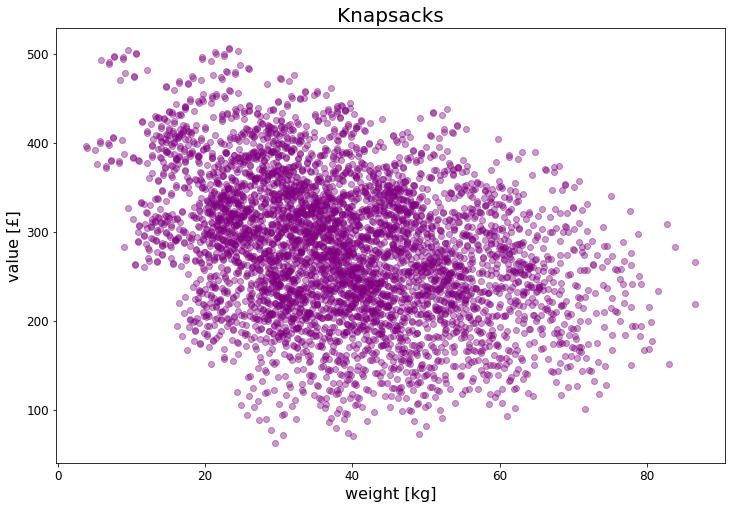

In [41]:
plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], 
            [knapsacks[idx]['value'] for idx in knapsacks], 
            alpha=0.4, color='purple')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
pass

Assuming you want to mimise the knapsack weight and maximise the value:  

* Which knapsack would you choose?
* If you could choose 3 knapsacks, which ones would you take?

# Solving With 1D Approach 

## Single Objective Optimisation

In [20]:
def knapsack_to_soh(package):
    return package['value'] / package['weight']

knapsacks_soh = {iknapsack: knapsack_to_soh(knapsack) for iknapsack, knapsack in knapsacks.items()}

Text(0.5, 1.0, 'Knapsack Single Objective Heuristic')

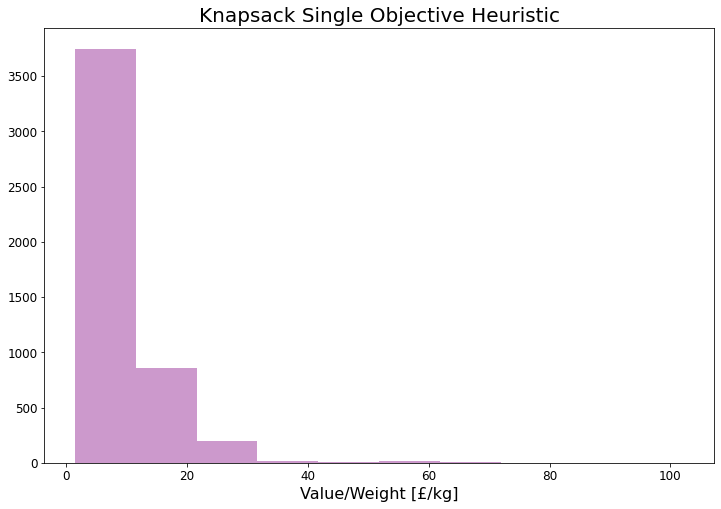

In [22]:
plt.hist(list(knapsacks_soh.values()), alpha=0.4, color='purple')
plt.xlabel('Value/Weight [£/kg]')
plt.title('Knapsack Single Objective Heuristic')

In [34]:
# soh - single objective heuristic
# soo - single objective optimal

max_soh = -1
iknapsack_soo = None

for iknapsack, soh in knapsacks_soh.items():
    if soh > max_soh:
        iknapsack_soo = int(iknapsack)
        max_soh = float(soh)
        
print(f'For Single Objective Optimisation \nknapsack {iknapsack_soo} is considered "optimal" with a heuristic value of {max_soh:0.1f}.')

For Single Objective Optimisation 
knapsack 4258 is considered "optimal" with a heuristic value of 102.2.


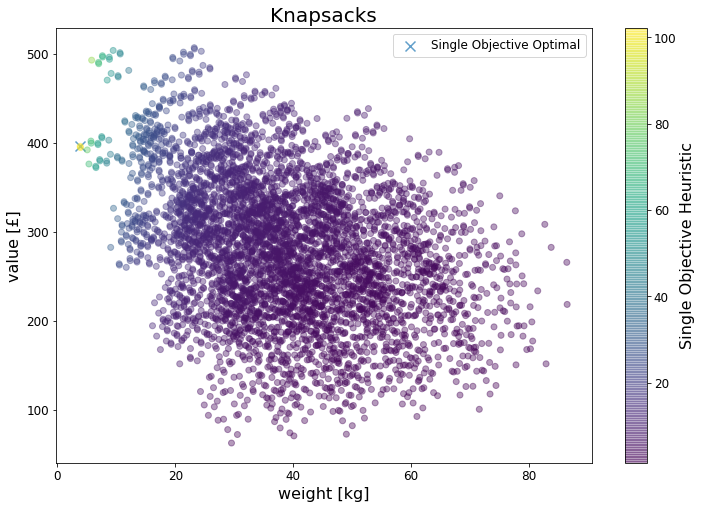

In [40]:
plt.scatter(knapsacks[iknapsack_soo]['weight'], knapsacks[iknapsack_soo]['value'], 
            marker='x', s=100, alpha=0.9, label='Single Objective', color='black', linewidth=3)

plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], 
            [knapsacks[idx]['value'] for idx in knapsacks], 
            alpha=0.1, c=np.array(list(knapsacks_soh.values())), cmap='viridis')

#

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
plt.colorbar(label='Single Objective Heuristic')
plt.legend(title='1D Optimal Solutions')

## Solving With Linear Search

In [ ]:
def linear_search_2d(knapsacks, objective1, objective2, top1=5, top2=1, reverse1=True, reverse2=True):
    knapsacks_sorted = {k: v for k, v in sorted(knapsacks.items(), key=lambda knapsack: knapsack[1][objective1], reverse=reverse1)} # 1 means value as opposed to key
    knapsacks_sorted_limited = {k: v for idx, (k, v) in enumerate(knapsacks_sorted.items()) if idx < top1}
    knapsacks_sorted_limited_optimal = {k: v for idx, (k, v) in enumerate(sorted(knapsacks_sorted_limited.items(), key=lambda knapsack: knapsack[1][objective2], reverse=reverse2)) if idx < top2}
    
    return list(knapsacks_sorted_limited_optimal.keys())
 
linear_value_first = linear_search_2d(knapsacks, 'value', 'weight', reverse1=True, reverse2=False, top1=5, top2=1)
linear_weight_first = linear_search_2d(knapsacks, 'weight', 'value', reverse1=False, reverse2=True, top1=5, top2=1)

In [ ]:
plt.scatter(knapsacks[iknapsack_soo]['weight'], knapsacks[iknapsack_soo]['value'], 
            marker='x', s=100, alpha=0.9, label='Single Objective', color='black', linewidth=3)

plt.scatter(knapsacks[linear_weight_first[0]]['weight'], knapsacks[linear_weight_first[0]]['value'], 
            marker='v', s=100, alpha=0.9, label='Weight First', color='black')

plt.scatter(knapsacks[linear_value_first[0]]['weight'], knapsacks[linear_value_first[0]]['value'], 
            marker='^', s=100, alpha=0.9, label='Value First', color='black')



plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], 
            [knapsacks[idx]['value'] for idx in knapsacks], 
            alpha=0.1, c=np.array(list(knapsacks_soh.values())), cmap='viridis')

#

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
plt.colorbar(label='Single Objective Heuristic')
plt.legend(title='1D Optimal Solutions')

# Pareto Front

In [42]:
from operator import lt as less_than, gt as greater_than

In [43]:
mode_to_operator = {'min': less_than, 'max': greater_than}

objective_mode = {'weight': 'min', 'value': 'max'}

objective_operator = {key: mode_to_operator[objective_mode[key]] for key in objective_mode.keys()}
objective_operator

{'weight': <function _operator.gt(a, b, /)>,
 'value': <function _operator.lt(a, b, /)>}

In [44]:
objective_values = {}

for objective in objectives:
    objective_values[objective] = [knapsacks[idx][objective] for idx in knapsacks]

In [45]:
objective_values.keys()

dict_keys(['weight', 'value'])

**Pareto Front Pseudo Code**  
Assuming a `knapsack` object with keys `weight`, `value`.  
This code aims at finding the Pareto Front that minimises for `weight` and maximises for `value`.  
We aim to create a list of knapsacks that consist of the Pareto Front called `pareto_front`.  


```
pareto_front = []

for this_knapsack in knapsacks:
    is_pareto = True   # we assume knapsack on the Pareto Front until proven otherwise
    
    other_knapsacks = knapsacks.remove(this_knapsack)
    
    for other_knapsack in other_knapsacks:
        # Does `other_knapsack` dominate `this_knapsack`?  
        other_dominates  = this_knapsack['weight'] > other_knapsacks['weight']
        other_dominates &= this_knapsack['value'] < other_knapsacks['value']
        
        if other_dominates:
            # knapsack dominated by at least one other knapsack, hence not pareto optimal
            is_pareto = False
            break  #  no need to compare with the rest of the other knapsacks
            
    if is_pareto:
        pareto_front.append(this_knapsack)
        

```

In [ ]:
idxs_pareto = [] 

for idx in range(len(objective_values[objective])):
    is_pareto = True  #  we assume on Pareto Front until proven otherwise
    
    # objective values of this knapsack
    this_weight = objective_values['weight'][idx]
    this_value = objective_values['value'][idx]
    
    # objective values of all the other knapsacks
    other_weights = np.array(objective_values['weight'][:idx] + objective_values['weight'][idx + 1:])
    other_values = np.array(objective_values['value'][:idx] + objective_values['value'][idx + 1:])
    
    for jdx in range(len(other_weights)):
        other_dominates = objective_operator['weight'](other_weights[jdx], this_weight) & objective_operator['value'](other_values[jdx], this_value)   
        
        if other_dominates:
            #  knapsack dominated by at least another, hence not pareto optimal.
            is_pareto = False
            break  #  no need to compare with the rest of the other knapsacks
            
    if is_pareto:
        idxs_pareto.append(idx)

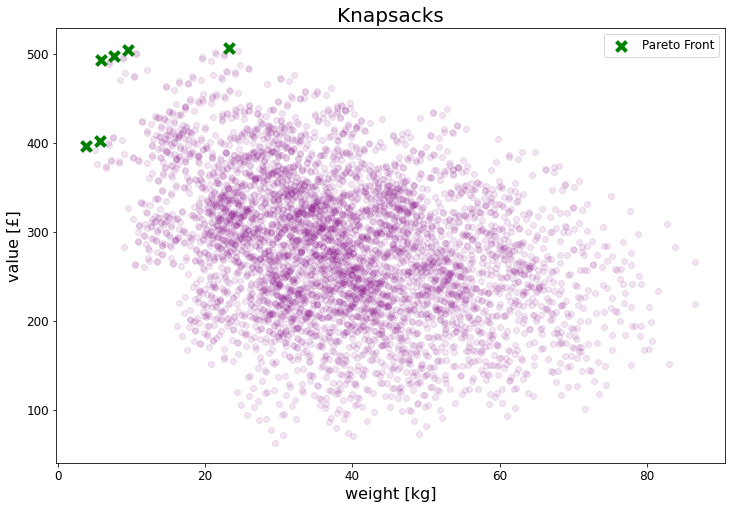

In [47]:
plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], [knapsacks[idx]['value'] for idx in knapsacks], alpha=0.1, color='purple')
plt.scatter([knapsacks[idx]['weight'] for idx in idxs_pareto], [knapsacks[idx]['value'] for idx in idxs_pareto], 
            marker='x', s=100, linewidth=4, color='green', label='Pareto Front')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
plt.legend()

Let's examine the packages of the Pareto optimal knapsacks.  

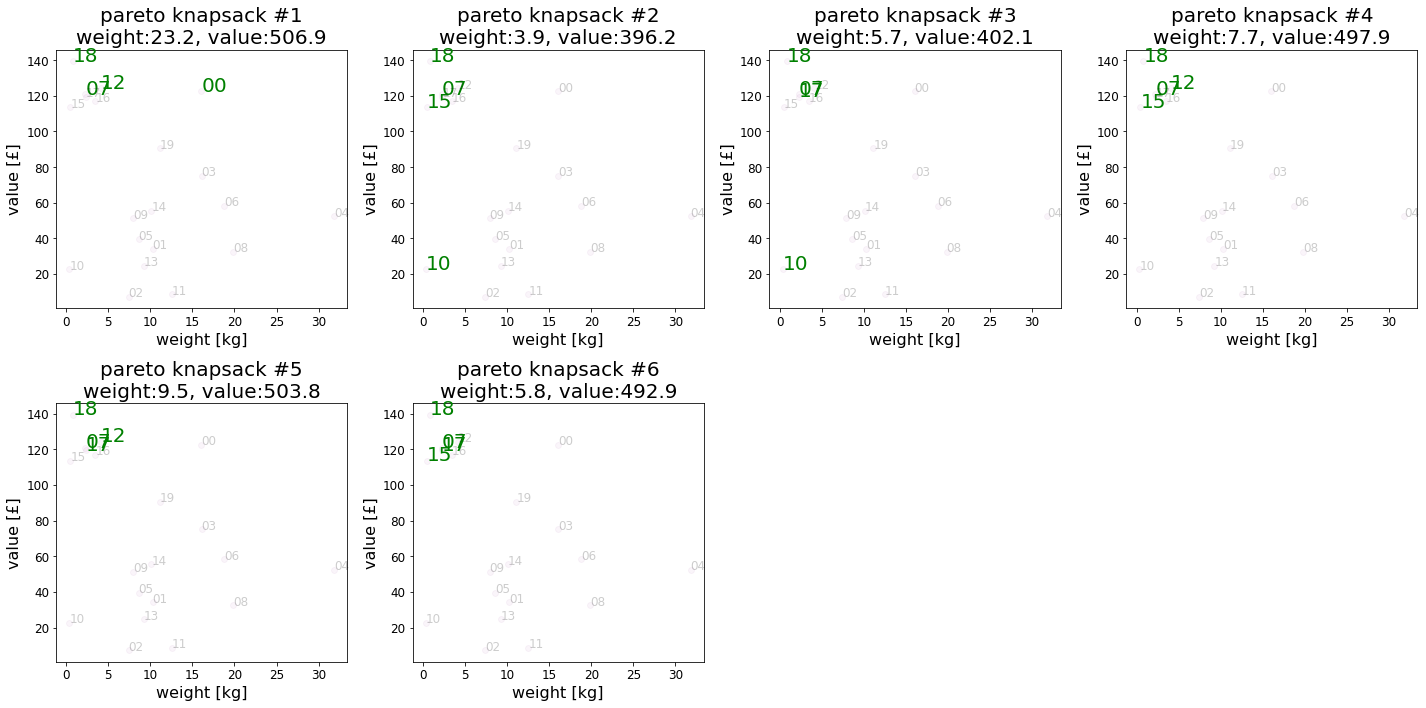

In [53]:
max_panels = 8
if len(idxs_pareto) > max_panels:
    np.random.seed(seed)
    idxs_pareto_plot = np.random.choice(idxs_pareto, max_panels, replace=False)
else:
    idxs_pareto_plot = idxs_pareto
    
npanels = len(idxs_pareto_plot)


ncols = 4
nrows = npanels // ncols + np.sum( (npanels % ncols) != 0)

plt.figure(figsize = (5 * ncols, 5 * nrows))

for ipanel, idx_pareto in enumerate(idxs_pareto_plot):
    plt.subplot(nrows, ncols, ipanel + 1)
    
    idx_packages_pareto = knapsacks[idx_pareto]['packages']

    plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
                [packages[idx_package]['value'] for idx_package in packages],
                color = 'purple', alpha=0.04
               )

    idx_packages_pareto = knapsacks[idx_pareto]['packages']

    for idx_package, package in packages.items():

        if idx_package in idx_packages_pareto:
            plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), color='green', fontsize=20)
        else:
            plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), alpha=0.2)
    
    title = f'knapsack {idx_pareto}'
    title += f'\nweight:{knapsacks[idx_pareto]["weight"]:0.1f}, value:{knapsacks[idx_pareto]["value"]:0.1f}'
    plt.title(title)
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    

plt.tight_layout()

# Decision Making With Pareto Fronts

Once the Pareto Front is identified it is your job as the analyst to present 
these results to the domain expert to discuss the next steps of the experiment/process.  
(Note: you the analyst might be that domain expert!*  


Most likely the domain expert will weigh in a subjective decision which will be depend on:
* How many solutions can be used for the next step. In our example, you might have four knapsack carriers, so you will want to give each one knapsack.   
* After seeing the exhaustive solution space how the domain expert might weigh the objectives. 


*For your own amusement (and education) I highly recommend watching [The Expert](https://www.youtube.com/watch?v=ObA9WGiQqLY&ab_channel=Adnan). This was recommended to me in my transition from academia to the private sector, and is an excellent life lesson on (mis)communication.  


# Rerun With A Larger Search Space?

In reality, however, you will deal with a much larger combinatorial space. 

In [62]:
N_PACKAGES = 40 
N_PACKAGES_PER_KNAPSACK = 20
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)/factorial(k)/factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 1.4e+11 combinations of 40 choose 20.'

In the case of a large intractable objective space we will need to use a stochastic method to navigate the combinatorial space.  

We will explore this in the next tutorial, which is accessible in Google Colab. To access press this button: 

<a href="https://colab.research.google.com/github/elzurdo/multi_objective_optimisation/blob/master/02_knapsack_2D_stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>